## Alexandre, Meiri, Thércio e Wesley

## Elabore modelos preditivos que classifiquem um comentário de restaurante com as seguintes classes:

### 1- elogio / não elogio
### 2 - reclamação / não reclamação
### 3..N - Para cada assunto identificado na tarefa anterior (5 no mínimo), crie uma classe para ser identificada pelo modelo preditivo.
### Aplique os modelos 1 e 2 no arquivo comentarios_test.csv e mostre os resultados de performance do modelo vencedor (acurácia, precisão, especificidade e f-measure)

# Preparação do notebook

In [160]:
# Código padrão para aumentar a largura do notebook

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [161]:
%%capture
from tqdm.notebook import tqdm

# Criação de barra de progresso

# Pré processamento - bases de treinamento e de testes

In [162]:
# Importação das bibliotecas, aumento da capacidade das colunas do Dataframe para conversão em string, preparação do ambiente nlp spacy e filtragem de warnings

from spacy.lang.pt.stop_words import STOP_WORDS
import unicodedata 
import re
import pandas as pd
import gensim
import spacy
from tqdm.notebook import tqdm
import warnings


import matplotlib.pyplot as plt 

from mlxtend import  plotting

pd.set_option("display.max_colwidth", 1000)
nlp = spacy.load('pt_core_news_sm')
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [77]:
# !python -m spacy download pt_core_news_sm

In [163]:
# Edição de stopwords do Spacy

remove_from_stopwords = []
add_to_stopwords = []

for word in remove_from_stopwords:
    nlp.Defaults.stop_words.remove(word)
for word in add_to_stopwords:
    nlp.Defaults.stop_words.add(word)

In [164]:
diretorio_arquivo =r'tarefa_final.xlsx'

In [165]:
# Importação dos dados, criação de dataframes e conversão em string (corpus)
base_testes = pd.read_excel(diretorio_arquivo, header=0, sheet_name='base_testes')



reclam_neutras = pd.read_excel(diretorio_arquivo, header=0, sheet_name='reclam_neutras')
elogios_neutras = pd.read_excel(diretorio_arquivo, header=0, sheet_name='elogios_neutras')
tempo = pd.read_excel(diretorio_arquivo, header=0, sheet_name='tempo')
atendimento = pd.read_excel(diretorio_arquivo, header=0, sheet_name='atendimento')
cardapio = pd.read_excel(diretorio_arquivo, header=0, sheet_name='cardapio')
pratos = pd.read_excel(diretorio_arquivo, header=0, sheet_name='pratos')
bebidas = pd.read_excel(diretorio_arquivo, header=0, sheet_name='bebidas')
ambiente = pd.read_excel(diretorio_arquivo, header=0, sheet_name='ambiente')
preco = pd.read_excel(diretorio_arquivo, header=0, sheet_name='preco')

In [88]:
base_testes.shape

(200, 15)

In [166]:
base_testes.isnull().sum()

id               0
avaliacao        0
titulo           0
texto            0
elogio           0
reclamacao       0
neutro           0
Unnamed: 7     200
tempo            0
atendimento      0
cardapio         0
pratos           0
bebidas          0
ambiente         0
preco            0
dtype: int64

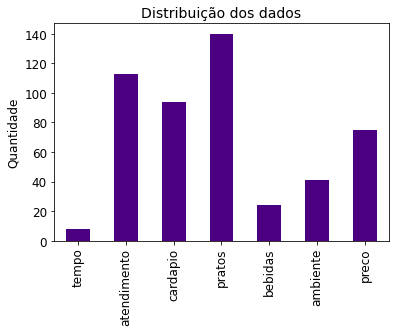

In [167]:
dados  =base_testes[["tempo","atendimento","cardapio","pratos","bebidas","ambiente","preco"]].sum()

ax = dados.plot(kind='bar', figsize=(6,4), color="indigo", fontsize=12);

ax.set_alpha(0.8)
ax.set_title("Distribuição dos dados", fontsize=14)
ax.set_ylabel("Quantidade", fontsize=12);
plt.show()

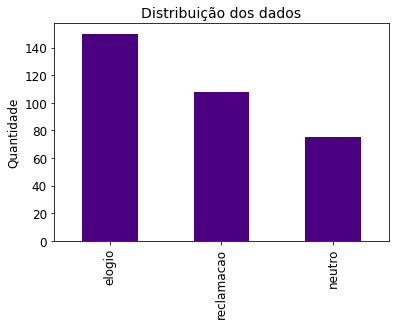

In [168]:

dados  =base_testes[["elogio","reclamacao","neutro"]].sum()

ax = dados.plot(kind='bar', figsize=(6,4), color="indigo", fontsize=12);

ax.set_alpha(0.8)
ax.set_title("Distribuição dos dados", fontsize=14)
ax.set_ylabel("Quantidade", fontsize=12);
plt.show()


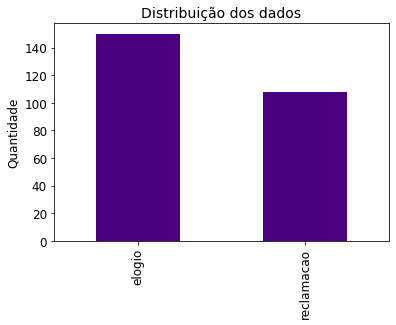

In [176]:

dados  =base_testes[["elogio","reclamacao"]].sum()

ax = dados.plot(kind='bar', figsize=(6,4), color="indigo", fontsize=12);

ax.set_alpha(0.8)
ax.set_title("Distribuição dos dados", fontsize=14)
ax.set_ylabel("Quantidade", fontsize=12);
plt.show()

In [169]:
# Remoção das reticências ao final dos comentários e substituição de hífen

texto_base_testes = pd.Series.to_string(base_testes['texto']).replace('...', ' ')

texto_reclam_neutras = pd.Series.to_string(reclam_neutras['texto']).replace('...', ' ')
texto_elogios_neutras = pd.Series.to_string(elogios_neutras['texto']).replace('...', ' ')
texto_tempo = pd.Series.to_string(tempo['texto']).replace('...', ' ')
texto_atendimento = pd.Series.to_string(atendimento['texto']).replace('...', ' ')
texto_cardapio = pd.Series.to_string(cardapio['texto']).replace('...', ' ')
texto_pratos = pd.Series.to_string(pratos['texto']).replace('...', ' ')
texto_bebidas = pd.Series.to_string(bebidas['texto']).replace('...', ' ')
texto_ambiente = pd.Series.to_string(ambiente['texto']).replace('...', ' ')
texto_preco = pd.Series.to_string(preco['texto']).replace('...', ' ')

texto_base_testes = pd.Series.to_string(base_testes['texto']).replace('-', ' ')

texto_reclam_neutras = pd.Series.to_string(reclam_neutras['texto']).replace('-', ' ')
texto_elogios_neutras = pd.Series.to_string(elogios_neutras['texto']).replace('-', ' ')
texto_tempo = pd.Series.to_string(tempo['texto']).replace('-', ' ')
texto_atendimento = pd.Series.to_string(atendimento['texto']).replace('-', ' ')
texto_cardapio = pd.Series.to_string(cardapio['texto']).replace('-', ' ')
texto_pratos = pd.Series.to_string(pratos['texto']).replace('-', ' ')
texto_bebidas = pd.Series.to_string(bebidas['texto']).replace('-', ' ')
texto_ambiente = pd.Series.to_string(ambiente['texto']).replace('-', ' ')
texto_preco = pd.Series.to_string(preco['texto']).replace('-', ' ')

In [76]:
# !pip install ipywidgets

In [170]:
# Pré-processamento: remoção de caracteres especiais e stopwords, transformação em minúsculas e lemmatization

frases_base_testes = [" ".join([token.lemma_ for token in nlp(" ".join(gensim.utils.simple_preprocess(re.sub('[^a-zA-Z0-9 \\\]', '', u"".join([c for c in unicodedata.normalize('NFKD', frase) \
 if not unicodedata.combining(c)]))))) if token.is_stop == False and len(token) > 2 ]) for frase in tqdm(texto_base_testes.splitlines())]


frases_reclam_neutras = [" ".join([token.lemma_ for token in nlp(" ".join(gensim.utils.simple_preprocess(re.sub('[^a-zA-Z0-9 \\\]', '', u"".join([c for c in unicodedata.normalize('NFKD', frase) \
 if not unicodedata.combining(c)]))))) if token.is_stop == False and len(token) > 2 ]) for frase in tqdm(texto_reclam_neutras.splitlines())]

frases_elogios_neutras = [" ".join([token.lemma_ for token in nlp(" ".join(gensim.utils.simple_preprocess(re.sub('[^a-zA-Z0-9 \\\]', '', u"".join([c for c in unicodedata.normalize('NFKD', frase) \
 if not unicodedata.combining(c)]))))) if token.is_stop == False and len(token) > 2 ]) for frase in tqdm(texto_elogios_neutras .splitlines())]

frases_tempo = [" ".join([token.lemma_ for token in nlp(" ".join(gensim.utils.simple_preprocess(re.sub('[^a-zA-Z0-9 \\\]', '', u"".join([c for c in unicodedata.normalize('NFKD', frase) \
 if not unicodedata.combining(c)]))))) if token.is_stop == False and len(token) > 2 ]) for frase in tqdm(texto_tempo .splitlines())]

frases_atendimento = [" ".join([token.lemma_ for token in nlp(" ".join(gensim.utils.simple_preprocess(re.sub('[^a-zA-Z0-9 \\\]', '', u"".join([c for c in unicodedata.normalize('NFKD', frase) \
 if not unicodedata.combining(c)]))))) if token.is_stop == False and len(token) > 2 ]) for frase in tqdm(texto_atendimento .splitlines())]

frases_cardapio = [" ".join([token.lemma_ for token in nlp(" ".join(gensim.utils.simple_preprocess(re.sub('[^a-zA-Z0-9 \\\]', '', u"".join([c for c in unicodedata.normalize('NFKD', frase) \
 if not unicodedata.combining(c)]))))) if token.is_stop == False and len(token) > 2 ]) for frase in tqdm(texto_cardapio .splitlines())]

frases_pratos = [" ".join([token.lemma_ for token in nlp(" ".join(gensim.utils.simple_preprocess(re.sub('[^a-zA-Z0-9 \\\]', '', u"".join([c for c in unicodedata.normalize('NFKD', frase) \
 if not unicodedata.combining(c)]))))) if token.is_stop == False and len(token) > 2 ]) for frase in tqdm(texto_pratos .splitlines())]

frases_bebidas = [" ".join([token.lemma_ for token in nlp(" ".join(gensim.utils.simple_preprocess(re.sub('[^a-zA-Z0-9 \\\]', '', u"".join([c for c in unicodedata.normalize('NFKD', frase) \
 if not unicodedata.combining(c)]))))) if token.is_stop == False and len(token) > 2 ]) for frase in tqdm(texto_bebidas .splitlines())]

frases_ambiente = [" ".join([token.lemma_ for token in nlp(" ".join(gensim.utils.simple_preprocess(re.sub('[^a-zA-Z0-9 \\\]', '', u"".join([c for c in unicodedata.normalize('NFKD', frase) \
 if not unicodedata.combining(c)]))))) if token.is_stop == False and len(token) > 2 ]) for frase in tqdm(texto_ambiente .splitlines())]

frases_preco = [" ".join([token.lemma_ for token in nlp(" ".join(gensim.utils.simple_preprocess(re.sub('[^a-zA-Z0-9 \\\]', '', u"".join([c for c in unicodedata.normalize('NFKD', frase) \
 if not unicodedata.combining(c)]))))) if token.is_stop == False and len(token) > 2 ]) for frase in tqdm(texto_preco .splitlines())]

In [171]:
# Inserção do texto pré-processado nos dataframes

base_testes.insert(3, 'texto_proc', frases_base_testes)

reclam_neutras.insert(3, 'texto_proc', frases_reclam_neutras) 
elogios_neutras.insert(3, 'texto_proc', frases_elogios_neutras) 
tempo.insert(3, 'texto_proc', frases_tempo) 
atendimento.insert(3, 'texto_proc', frases_atendimento) 
cardapio.insert(3, 'texto_proc', frases_cardapio) 
pratos.insert(3, 'texto_proc', frases_pratos) 
bebidas.insert(3, 'texto_proc', frases_bebidas) 
ambiente.insert(3, 'texto_proc', frases_ambiente) 
preco.insert(3, 'texto_proc', frases_preco) 

# Treinamento e testes

In [177]:
# Importação das bibliotecas de treinamento e teste

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix


In [185]:
def plot_confusion_matrix(y_prediction,target_set,title):
    cm = confusion_matrix(y_prediction,target_set)

# from mlxtend.plotting import plot_confusion_matrix
    fig, ax = plotting.plot_confusion_matrix(conf_mat=cm ,figsize=(5, 5),
                            show_absolute=True,
                            show_normed=True,
                            colorbar=True,
                            
                            )
  
    ax.set_title(title)
    plt.show()

## reclamações | não-reclamações

In [178]:
# Criação de ngrams e vetorização da coluna de textos para treinamento

vect = TfidfVectorizer(ngram_range=(1,4), use_idf=True, min_df=1, max_df=0.95)
vect.fit(reclam_neutras.texto_proc)
text_vect = vect.transform(reclam_neutras.texto_proc)

# Definição de variáveis e target para treino

x_train = text_vect
y_train = reclam_neutras.avaliacao

# Treinamento do modelo com LinearSVC (Linear Support Vector Classification)

clf = LinearSVC(C=10, random_state=0)
clf.fit(x_train, y_train)

# Criação de ngrams e vetorização da coluna de textos para predição

vect_2 = TfidfVectorizer(ngram_range=(1,4), use_idf=True, min_df=1, max_df=0.95)
vect_2.fit(base_testes.texto_proc)
text_vect_2 = vect.transform(base_testes.texto_proc)

# Realização das predições (classificações)

y_prediction = clf.predict(text_vect_2)

 

print('\t\t reclamações | não-reclamações\n')
print(classification_report(y_prediction, base_testes.reclamacao))

reclamações | não-reclamações

              precision    recall  f1-score   support

           0       0.82      0.68      0.74       111
           1       0.67      0.81      0.73        89

    accuracy                           0.73       200
   macro avg       0.74      0.74      0.73       200
weighted avg       0.75      0.73      0.74       200



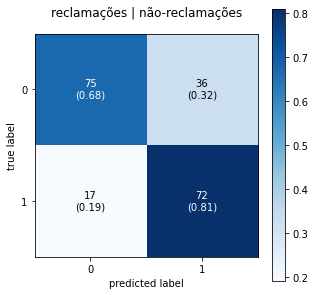

In [186]:
plot_confusion_matrix(y_prediction,base_testes.reclamacao,"reclamações | não-reclamações")

## elogios | não-elogios

In [193]:
# Criação de ngrams e vetorização da coluna de textos para treinamento

vect = TfidfVectorizer(ngram_range=(1,4), use_idf=True, min_df=1, max_df=0.95)
vect.fit(elogios_neutras.texto_proc)
text_vect = vect.transform(elogios_neutras.texto_proc)

# Definição de variáveis e target para treino

x_train = text_vect
y_train = elogios_neutras.avaliacao

# Treinamento do modelo com LinearSVC (Linear Support Vector Classification)

clf = LinearSVC(C=10, random_state=0)
clf.fit(x_train, y_train)

# Criação de ngrams e vetorização da coluna de textos para predição

vect_2 = TfidfVectorizer(ngram_range=(1,4), use_idf=True, min_df=1, max_df=0.95)
vect_2.fit(base_testes.texto_proc)
text_vect_2 = vect.transform(base_testes.texto_proc)

# Realização das predições (classificações)

y_prediction = clf.predict(text_vect_2)

print('\t\t elogios | não-elogios\n')
print(classification_report(y_prediction, base_testes.elogio))

elogios | não-elogios

              precision    recall  f1-score   support

           0       0.74      0.54      0.63        68
           1       0.79      0.90      0.84       132

    accuracy                           0.78       200
   macro avg       0.77      0.72      0.74       200
weighted avg       0.78      0.78      0.77       200



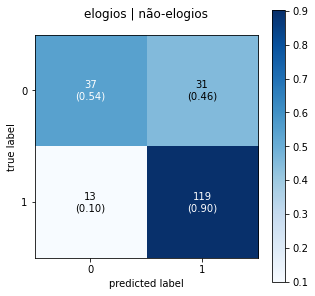

In [194]:
plot_confusion_matrix(y_prediction,base_testes.elogio,"elogios | não-elogios")

## tópico tempo

In [198]:
# Criação de ngrams e vetorização da coluna de textos para treinamento

vect = TfidfVectorizer(ngram_range=(1,4), use_idf=True, min_df=1, max_df=0.95)
vect.fit(tempo.texto_proc)
text_vect = vect.transform(tempo.texto_proc)

# Definição de variáveis e target para treino

x_train = text_vect
y_train = tempo.avaliacao

# Treinamento do modelo com LinearSVC (Linear Support Vector Classification)

clf = LinearSVC(C=10, random_state=0)
clf.fit(x_train, y_train)

# Criação de ngrams e vetorização da coluna de textos para predição

vect_2 = TfidfVectorizer(ngram_range=(1,4), use_idf=True, min_df=1, max_df=0.95)
vect_2.fit(base_testes.texto_proc)
text_vect_2 = vect.transform(base_testes.texto_proc)

# Realização das predições (classificações)

y_prediction = clf.predict(text_vect_2)

print('\t\t\t tópico tempo\n')
print(classification_report(y_prediction, base_testes.tempo))

tópico tempo

              precision    recall  f1-score   support

           0       0.84      0.97      0.90       167
           1       0.38      0.09      0.15        33

    accuracy                           0.82       200
   macro avg       0.61      0.53      0.52       200
weighted avg       0.77      0.82      0.78       200



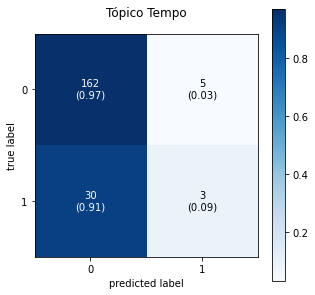

In [199]:
plot_confusion_matrix(y_prediction,base_testes.tempo,"Tópico Tempo")

## tópico atendimento

In [200]:
# Criação de ngrams e vetorização da coluna de textos para treinamento

vect = TfidfVectorizer(ngram_range=(1,4), use_idf=True, min_df=1, max_df=0.95)
vect.fit(atendimento.texto_proc)
text_vect = vect.transform(atendimento.texto_proc)

# Definição de variáveis e target para treino

x_train = text_vect
y_train = atendimento.avaliacao

# Treinamento do modelo com LinearSVC (Linear Support Vector Classification)

clf = LinearSVC(C=10, random_state=0)
clf.fit(x_train, y_train)

# Criação de ngrams e vetorização da coluna de textos para predição

vect_2 = TfidfVectorizer(ngram_range=(1,4), use_idf=True, min_df=1, max_df=0.95)
vect_2.fit(base_testes.texto_proc)
text_vect_2 = vect.transform(base_testes.texto_proc)

# Realização das predições (classificações)

y_prediction = clf.predict(text_vect_2)

print('\t\t\t tópico atendimento\n')
print(classification_report(y_prediction, base_testes.atendimento))

tópico atendimento

              precision    recall  f1-score   support

           0       0.95      0.55      0.70       151
           1       0.40      0.92      0.56        49

    accuracy                           0.64       200
   macro avg       0.68      0.73      0.63       200
weighted avg       0.82      0.64      0.66       200



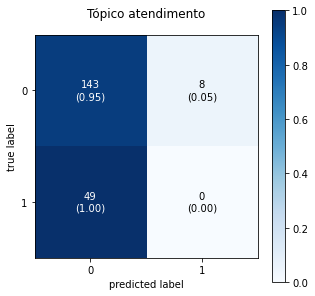

In [201]:
plot_confusion_matrix(y_prediction,base_testes.tempo,"Tópico atendimento")


## tópico cardápio

In [202]:
# Criação de ngrams e vetorização da coluna de textos para treinamento

vect = TfidfVectorizer(ngram_range=(1,4), use_idf=True, min_df=1, max_df=0.95)
vect.fit(cardapio.texto_proc)
text_vect = vect.transform(cardapio.texto_proc)

# Definição de variáveis e target para treino

x_train = text_vect
y_train = cardapio.avaliacao

# Treinamento do modelo com LinearSVC (Linear Support Vector Classification)

clf = LinearSVC(C=10, random_state=0)
clf.fit(x_train, y_train)

# Criação de ngrams e vetorização da coluna de textos para predição

vect_2 = TfidfVectorizer(ngram_range=(1,4), use_idf=True, min_df=1, max_df=0.95)
vect_2.fit(base_testes.texto_proc)
text_vect_2 = vect.transform(base_testes.texto_proc)

# Realização das predições (classificações)

y_prediction = clf.predict(text_vect_2)

print('\t\t\t tópico cardápio\n')
print(classification_report(y_prediction, base_testes.cardapio))

tópico cardápio

              precision    recall  f1-score   support

           0       0.88      0.68      0.77       136
           1       0.54      0.80      0.65        64

    accuracy                           0.72       200
   macro avg       0.71      0.74      0.71       200
weighted avg       0.77      0.72      0.73       200



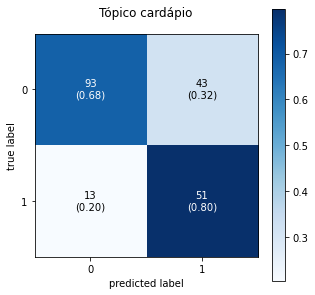

In [203]:
plot_confusion_matrix(y_prediction,base_testes.cardapio,"Tópico cardápio")



## tópico pratos

In [205]:
# Criação de ngrams e vetorização da coluna de textos para treinamento

vect = TfidfVectorizer(ngram_range=(1,4), use_idf=True, min_df=1, max_df=0.95)
vect.fit(pratos.texto_proc)
text_vect = vect.transform(pratos.texto_proc)

# Definição de variáveis e target para treino

x_train = text_vect
y_train = pratos.avaliacao

# Treinamento do modelo com LinearSVC (Linear Support Vector Classification)

clf = LinearSVC(C=10, random_state=0)
clf.fit(x_train, y_train)

# Criação de ngrams e vetorização da coluna de textos para predição

vect_2 = TfidfVectorizer(ngram_range=(1,4), use_idf=True, min_df=1, max_df=0.95)
vect_2.fit(base_testes.texto_proc)
text_vect_2 = vect.transform(base_testes.texto_proc)

# Realização das predições (classificações)

y_prediction = clf.predict(text_vect_2)

print('\t\t\t tópico pratos\n')
print(classification_report(y_prediction, base_testes.pratos))

tópico pratos

              precision    recall  f1-score   support

           0       0.83      0.33      0.47       151
           1       0.28      0.80      0.41        49

    accuracy                           0.45       200
   macro avg       0.56      0.56      0.44       200
weighted avg       0.70      0.45      0.46       200



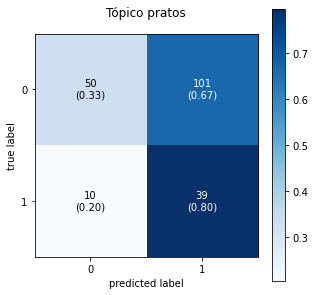

In [206]:
plot_confusion_matrix(y_prediction,base_testes.pratos,"Tópico pratos")

## tópico bebidas

In [207]:
# Criação de ngrams e vetorização da coluna de textos para treinamento

vect = TfidfVectorizer(ngram_range=(1,4), use_idf=True, min_df=1, max_df=0.95)
vect.fit(bebidas.texto_proc)
text_vect = vect.transform(bebidas.texto_proc)

# Definição de variáveis e target para treino

x_train = text_vect
y_train = bebidas.avaliacao

# Treinamento do modelo com LinearSVC (Linear Support Vector Classification)

clf = LinearSVC(C=10, random_state=0)
clf.fit(x_train, y_train)

# Criação de ngrams e vetorização da coluna de textos para predição

vect_2 = TfidfVectorizer(ngram_range=(1,4), use_idf=True, min_df=1, max_df=0.95)
vect_2.fit(base_testes.texto_proc)
text_vect_2 = vect.transform(base_testes.texto_proc)

# Realização das predições (classificações)

y_prediction = clf.predict(text_vect_2)

print('\t\t\t tópico bebidas\n')
print(classification_report(y_prediction, base_testes.bebidas))

tópico bebidas

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       190
           1       0.17      0.40      0.24        10

    accuracy                           0.87       200
   macro avg       0.57      0.65      0.58       200
weighted avg       0.93      0.87      0.89       200



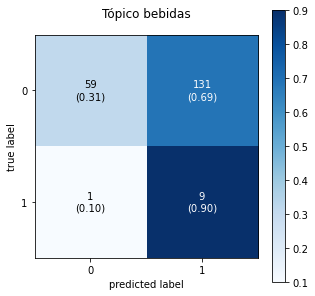

In [208]:
plot_confusion_matrix(y_prediction,base_testes.pratos,"Tópico bebidas")

## tópico ambiente

In [209]:
# Criação de ngrams e vetorização da coluna de textos para treinamento

vect = TfidfVectorizer(ngram_range=(1,4), use_idf=True, min_df=1, max_df=0.95)
vect.fit(ambiente.texto_proc)
text_vect = vect.transform(ambiente.texto_proc)

# Definição de variáveis e target para treino

x_train = text_vect
y_train = ambiente.avaliacao

# Treinamento do modelo com LinearSVC (Linear Support Vector Classification)

clf = LinearSVC(C=10, random_state=0)
clf.fit(x_train, y_train)

# Criação de ngrams e vetorização da coluna de textos para predição

vect_2 = TfidfVectorizer(ngram_range=(1,4), use_idf=True, min_df=1, max_df=0.95)
vect_2.fit(base_testes.texto_proc)
text_vect_2 = vect.transform(base_testes.texto_proc)

# Realização das predições (classificações)

y_prediction = clf.predict(text_vect_2)

print('\t\t\t tópico ambiente\n')
print(classification_report(y_prediction, base_testes.ambiente))

tópico ambiente

              precision    recall  f1-score   support

           0       0.94      0.83      0.88       180
           1       0.24      0.50      0.33        20

    accuracy                           0.80       200
   macro avg       0.59      0.66      0.60       200
weighted avg       0.87      0.80      0.82       200



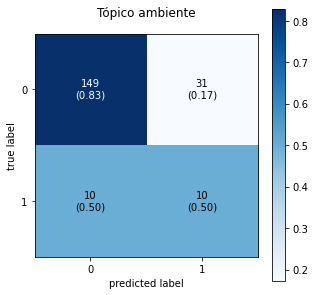

In [210]:
plot_confusion_matrix(y_prediction,base_testes.ambiente,"Tópico ambiente")

## tópico preço

In [212]:
# Criação de ngrams e vetorização da coluna de textos para treinamento

vect = TfidfVectorizer(ngram_range=(1,4), use_idf=True, min_df=1, max_df=0.95)
vect.fit(preco.texto_proc)
text_vect = vect.transform(preco.texto_proc)

# Definição de variáveis e target para treino

x_train = text_vect
y_train = preco.avaliacao

# Treinamento do modelo com LinearSVC (Linear Support Vector Classification)

clf = LinearSVC(C=10, random_state=0)
clf.fit(x_train, y_train)

# Criação de ngrams e vetorização da coluna de textos para predição

vect_2 = TfidfVectorizer(ngram_range=(1,4), use_idf=True, min_df=1, max_df=0.95)
vect_2.fit(base_testes.texto_proc)
text_vect_2 = vect.transform(base_testes.texto_proc)

# Realização das predições (classificações)

y_prediction = clf.predict(text_vect_2)

print('\t\t\t tópico preço\n')
print(classification_report(y_prediction, base_testes.preco))

tópico preço

              precision    recall  f1-score   support

           0       0.93      0.78      0.85       148
           1       0.57      0.83      0.68        52

    accuracy                           0.80       200
   macro avg       0.75      0.81      0.76       200
weighted avg       0.84      0.80      0.80       200



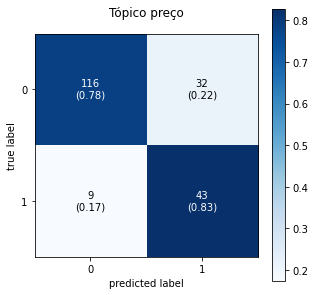

In [213]:
plot_confusion_matrix(y_prediction,base_testes.preco,"Tópico preço")